<a href="https://colab.research.google.com/github/Ed-Cheng/Potential-Stock-Finder/blob/main/AfterHours_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Must run (Nothing to change after personalized)

## Install and initialize functions



In [ ]:
pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import yfinance as yf
import pandas as pd
import numpy as np
import mplfinance as fplt

from datetime import datetime, timedelta
from pandas_datareader import data
from tqdm import tqdm


In [ ]:
def fetch_stock(target_stock, start_date, end_date):
  """ Read the stock data """
  yf.pdr_override()
  # read and save pandas df
  df = data.get_data_yahoo([target_stock], start_date, end_date, progress=False)
  # fill in missing values, if any
  df = df.interpolate()
  # df.index = pd.to_datetime(df.index)
  # df = df[["Open", "Close", "Volume"]]

  return df

def add_indicator(stock_df):
  """ 
    Relative volume change compared to today
    Past x days' price change
  """

  stock_df["InDayChg"] = 100*(stock_df["Close"] - stock_df["Open"])/stock_df["Open"]
  stock_df["PriceChg"] = 100*(stock_df["Close"] - stock_df.shift(1)["Close"])/stock_df.shift(1)["Close"]

  indicator_days = [3, 5, 10, 20]
  for days in indicator_days:
    # Price Moving Average (MA) 
    stock_df[f"MA{days}"] = stock_df["Close"].rolling(days).mean()

    # Volume Moving Average (VMA) 
    stock_df[f"VMA{days}"] = stock_df["Volume"].rolling(days).mean()

    # Volume Moving Average (VMA) relative to today's volume
    stock_df[f"relVMA{days}"] = stock_df["Volume"]/stock_df[f"VMA{days}"]



def candle_plot(stock_df, title):
  VMA5 = fplt.make_addplot(stock_df["VMA5"], color="red", width=1.5, panel=1)
  VMA10 = fplt.make_addplot(stock_df["VMA10"], color="orange", width=1.5, panel=1)
  VMA20 = fplt.make_addplot(stock_df["VMA20"], color="purple", width=1.5, panel=1)

  fplt.plot(stock_df,
            type='candle',
            addplot = [VMA5, VMA10, VMA20],
            # style='charles',
            mav=(5, 10, 20),
            mavcolors=["red", "orange", "purple"],
            xlim=(len(stock_df)-40, len(stock_df)),
            title=title,
            ylabel='Price',
            volume=True,
            ylabel_lower='Volume')


def load_data(symbol_list, ago, tdy):
  # Store stock details for plotting
  detail_dict = {}

  for i, firm in enumerate(tqdm(symbol_list)):
    if firm and "." not in firm:
      stock = fetch_stock(firm, ago, tdy)
      add_indicator(stock)
      detail_dict[firm] = stock.copy()

  return detail_dict

## Load ticker list from Wiki (Russell, S&P500...)


In [ ]:
# sp500_table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
# sp500_list = list(sp500_table[0]["Symbol"])
russell_table = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")
russell_list = list(russell_table[2]["Ticker"])
industry_list = list(russell_table[2]["GICS Sector"])

## Load personal ticker list from google drive (If applicable)
Comment this section out if don't have a personal list

In [ ]:
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
worksheet = gc.open("ticker_list").sheet1
#get_all_values gives a list of rows
rows = worksheet.get_all_values()
#Convert to a DataFrame 
df = pd.DataFrame(rows)
df.columns = df.iloc[0]
my_list = df[1:] # Includes Us_all, Meme, Holdings_Focus

## Check the date for analysis
Check if market is open; the time zone may be different, etc

In [ ]:
tdy = datetime.now()
tdy = datetime.now() - timedelta(days=1)

# Quarter of a year (3 months)
qtr = 90
ago = datetime.now() - timedelta(days=qtr)
print(tdy)

2023-06-01 15:52:36.038761


## Load symbols in the list

In [ ]:
russell = load_data(russell_list, ago, tdy)
us_all = load_data(list(my_list["Us_all"]), ago, tdy)
meme = load_data(list(my_list["Meme"]), ago, tdy)
focus = load_data(list(my_list["Holdings_Focus"]), ago, tdy)

100%|██████████| 44/44 [00:02<00:00, 16.96it/s]


# Quick Check "Focus" & "Meme" tickers
- Quick overview of personally selected stocks

ABNB


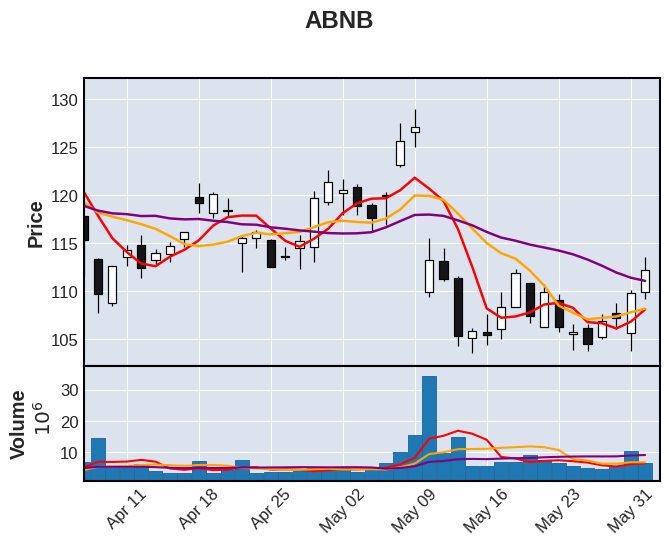

AMD


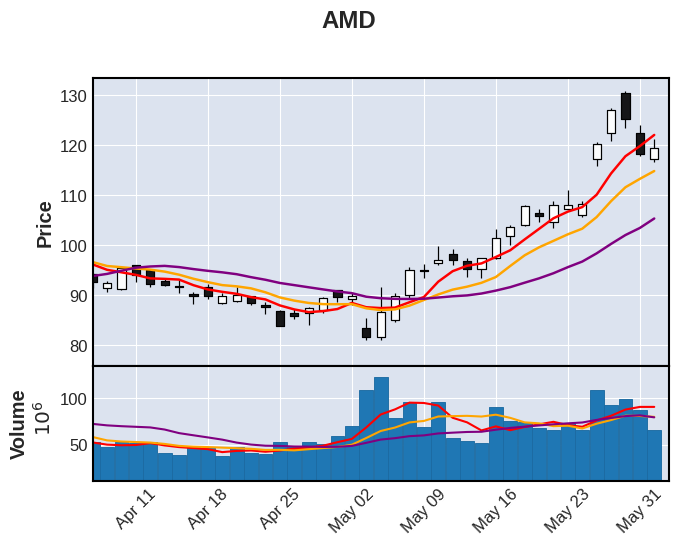

AMZN


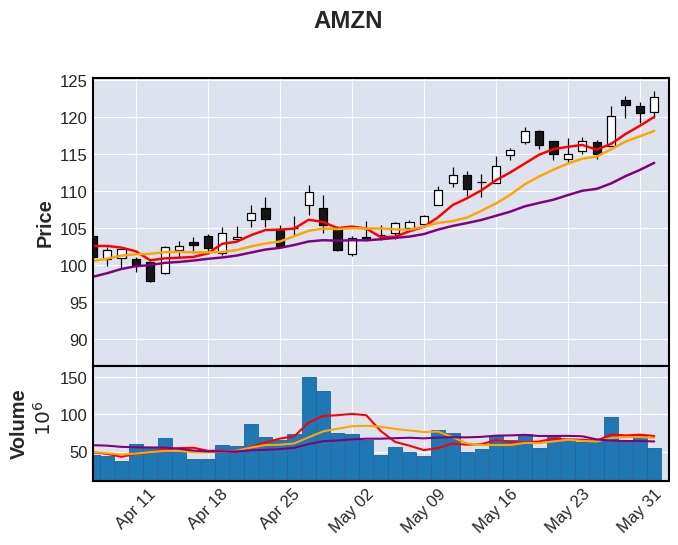

BAC


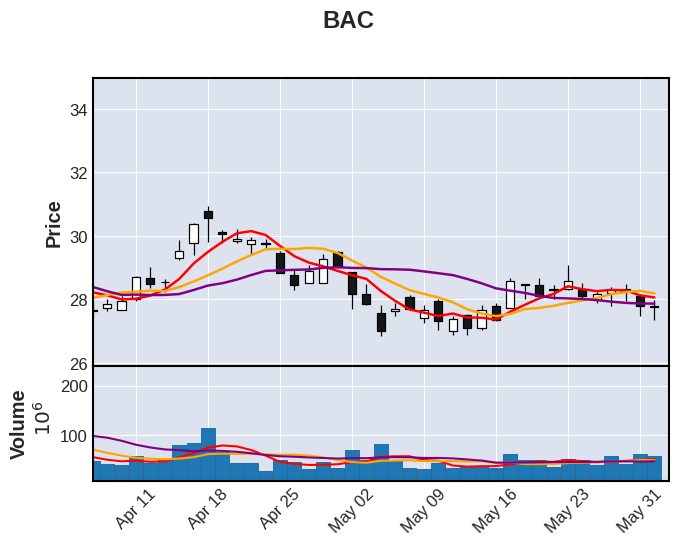

DDOG


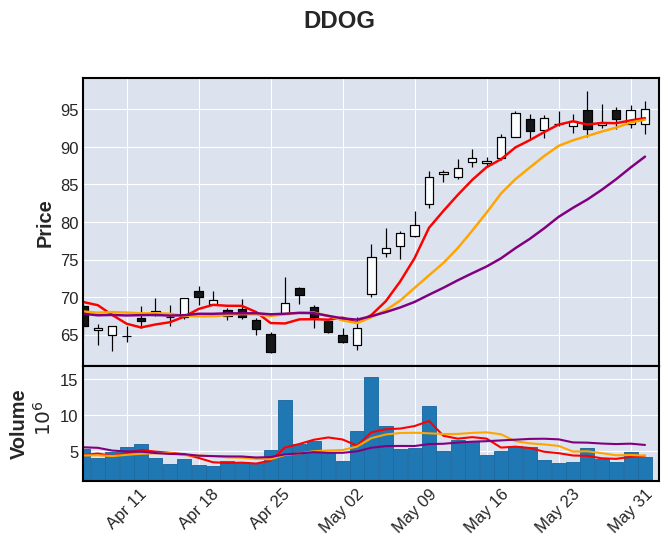

GOOG


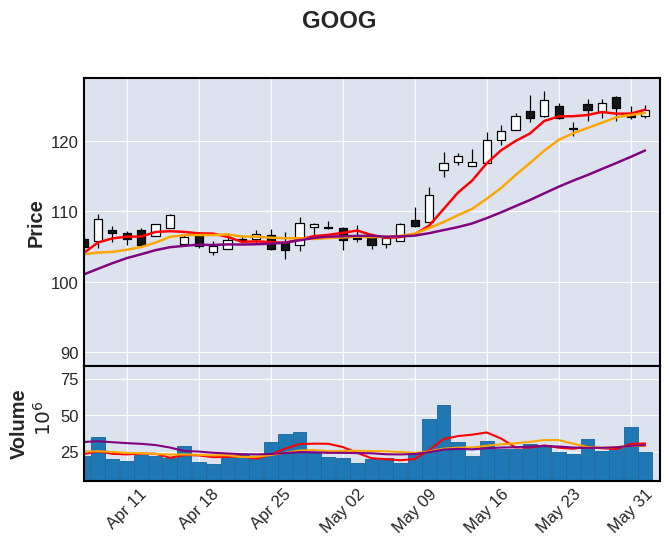

LMND


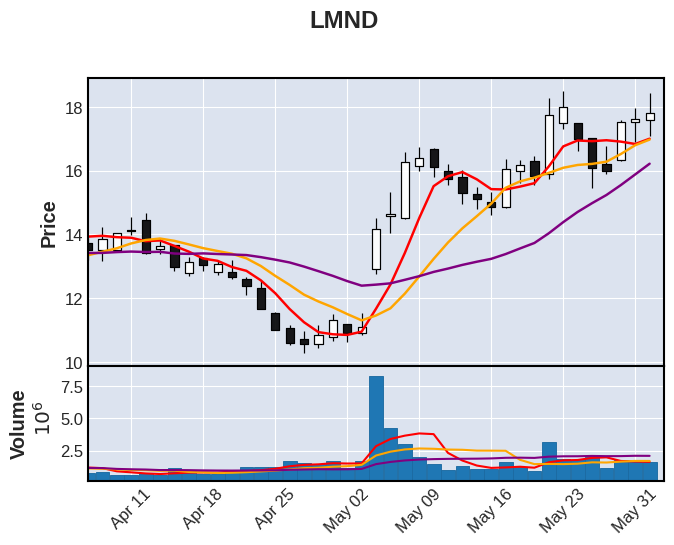

LYFT


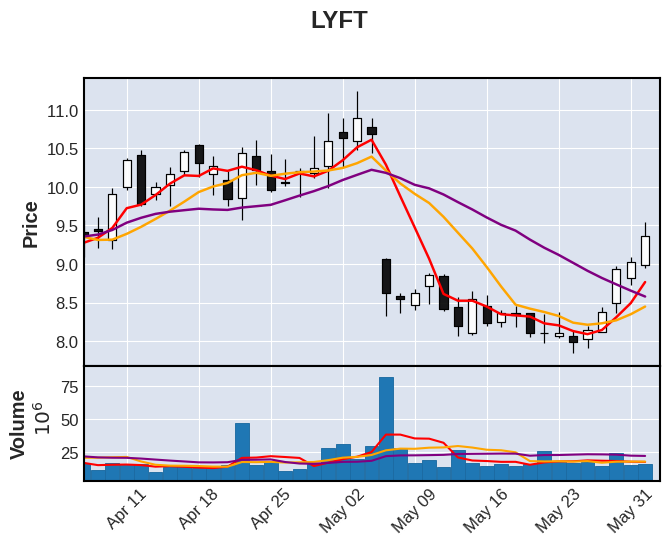

MSFT


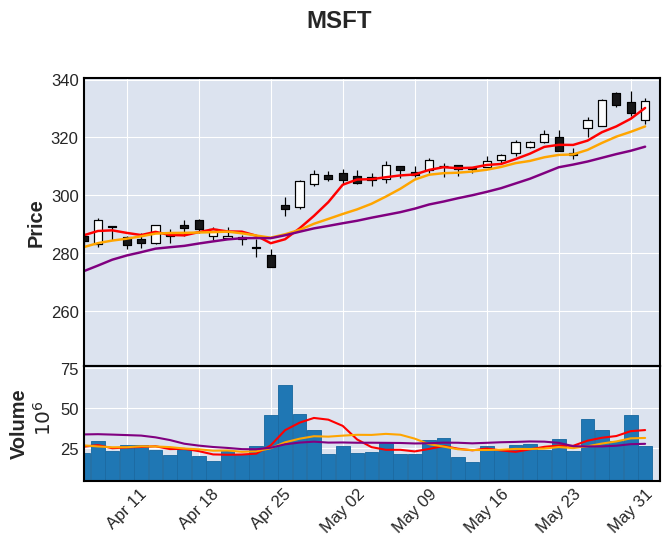

MU


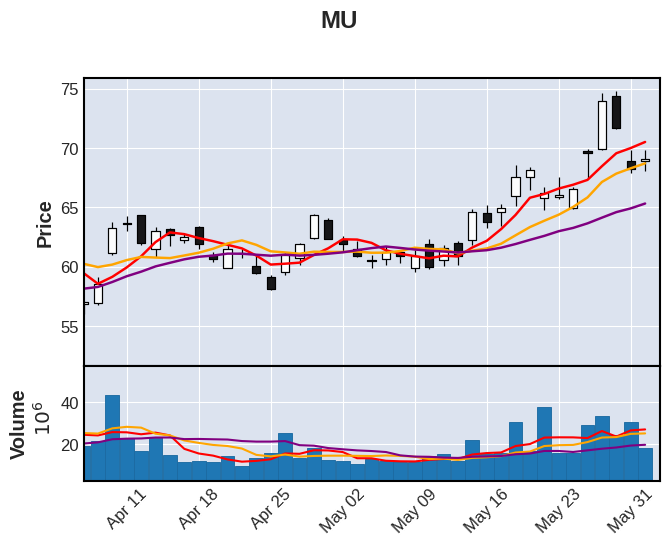

NVDA


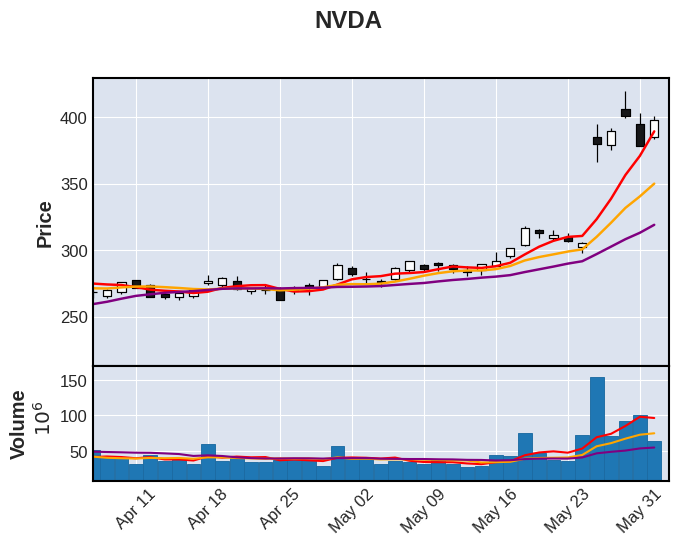

ON


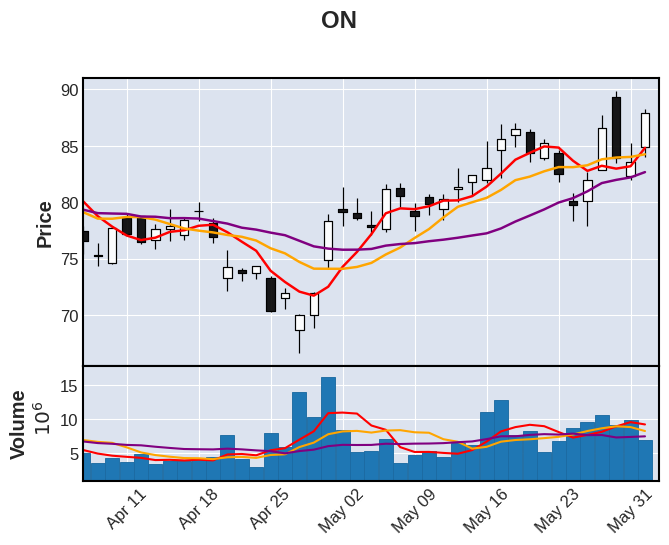

ORCL


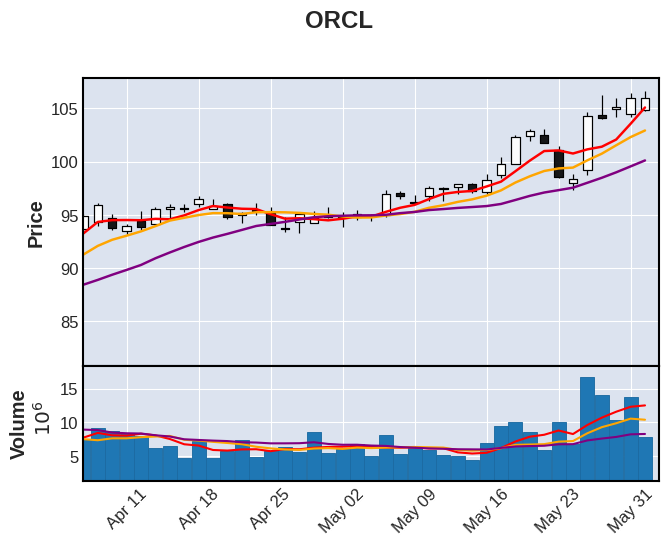

SNOW


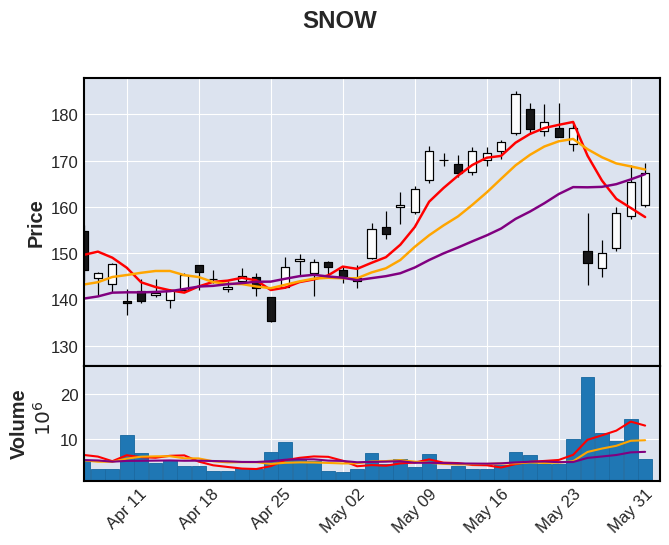

TSM


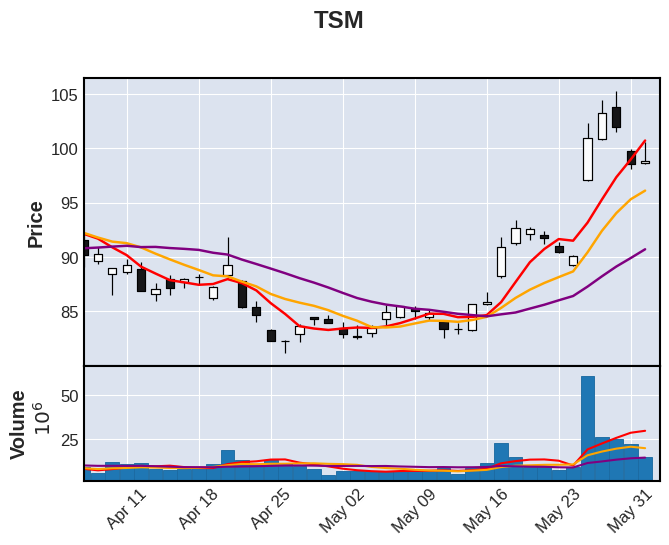

TTD


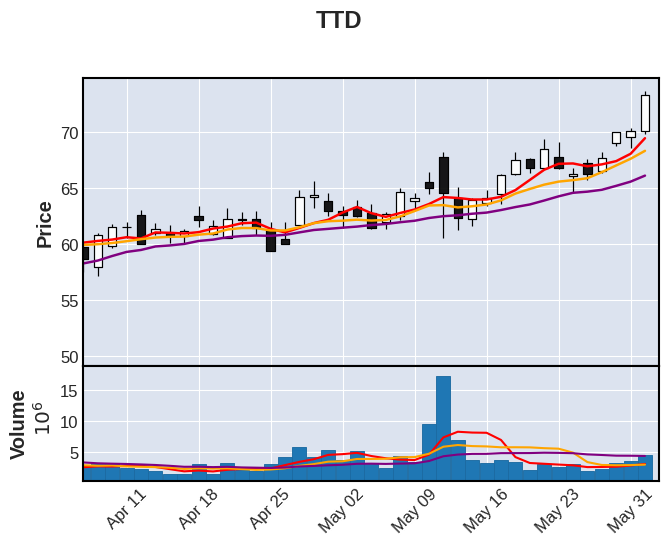

UPST


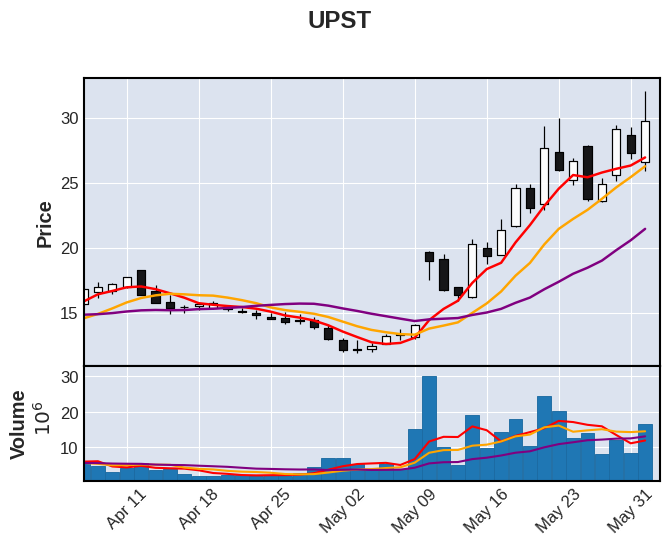

In [ ]:
for key in focus.keys():
  print(f"{key}")
  candle_plot(focus[key], key)

AFRM


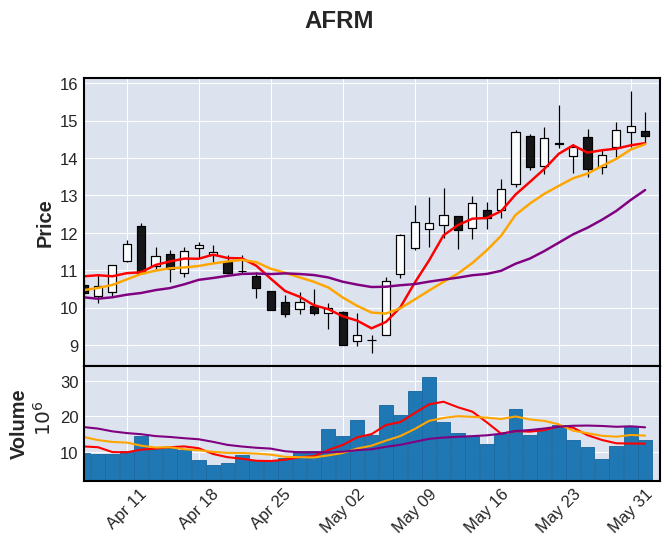

AI


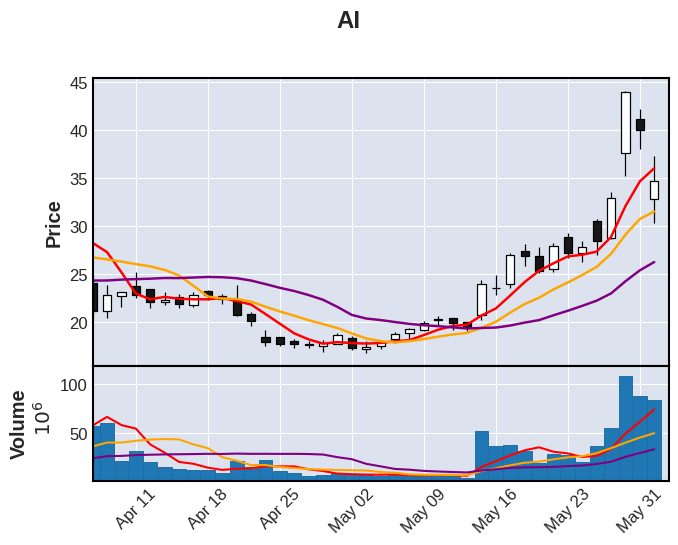

AMC


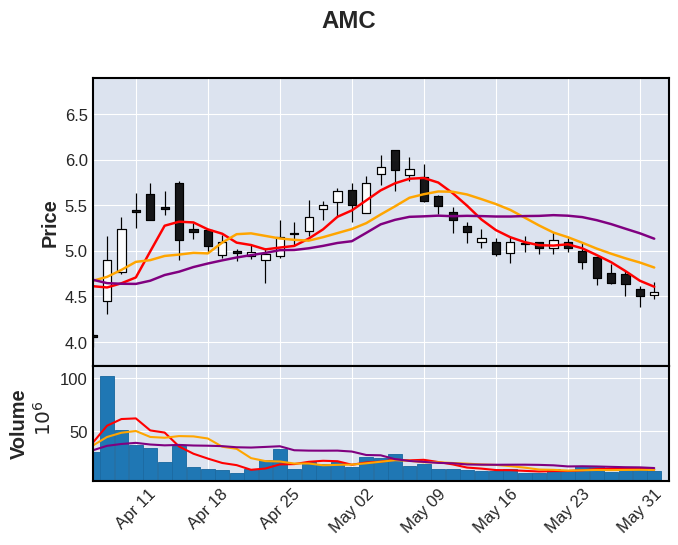

BB


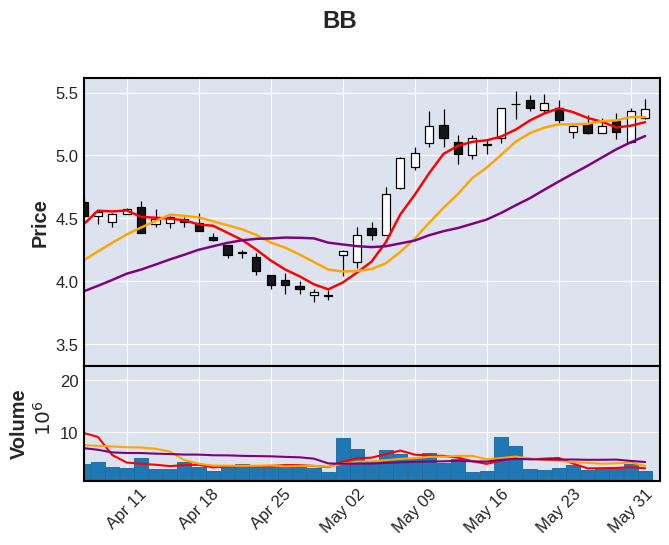

BIGC


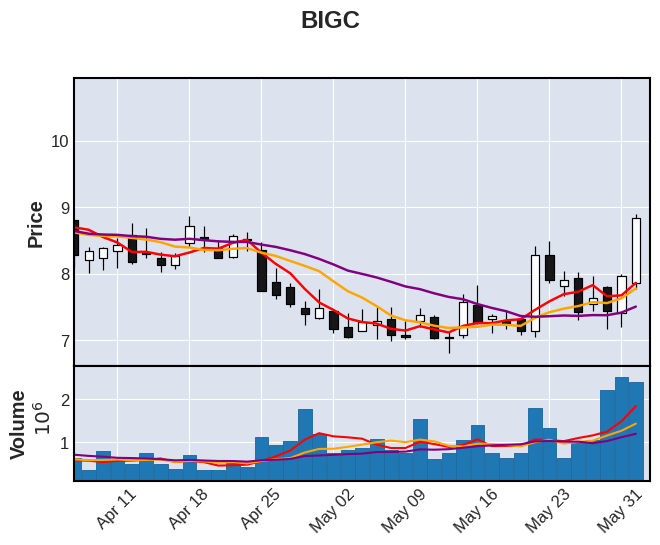

CHPT


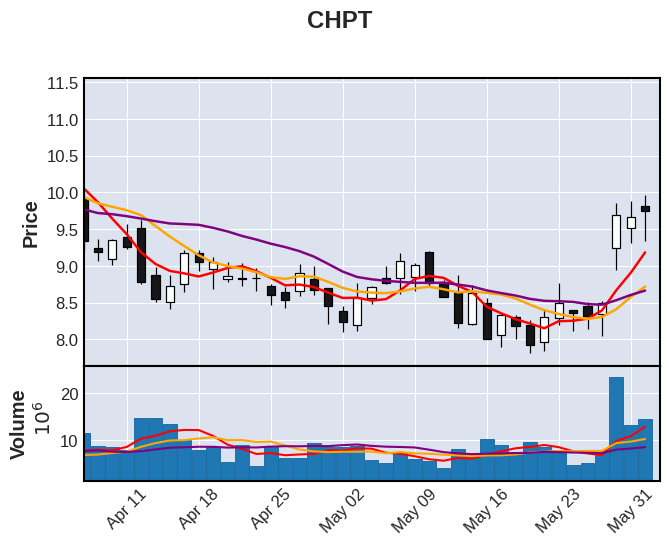

COIN


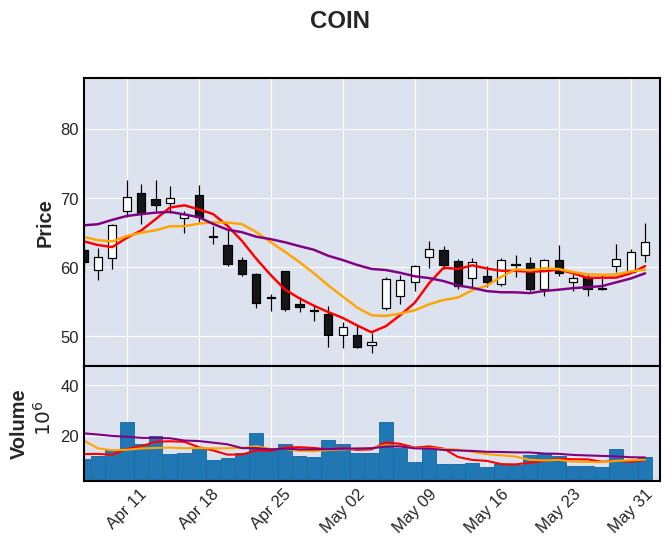

DKNG


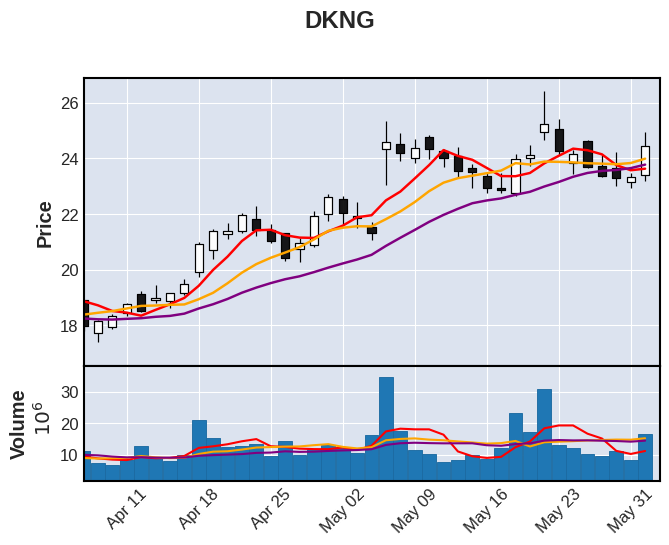

DKS


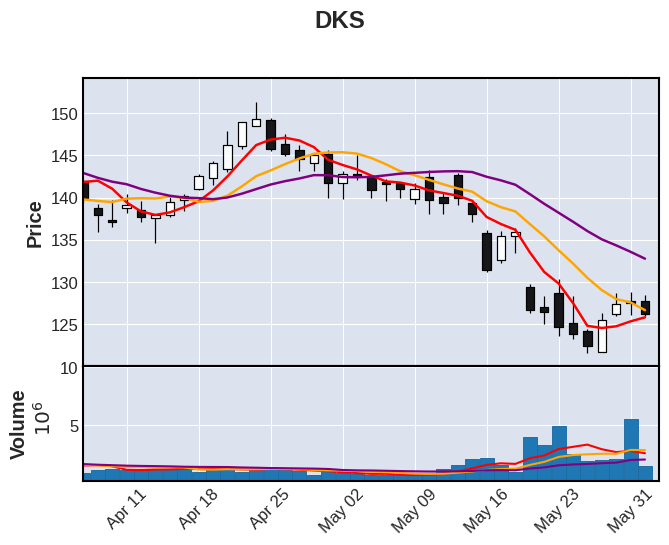

DOCU


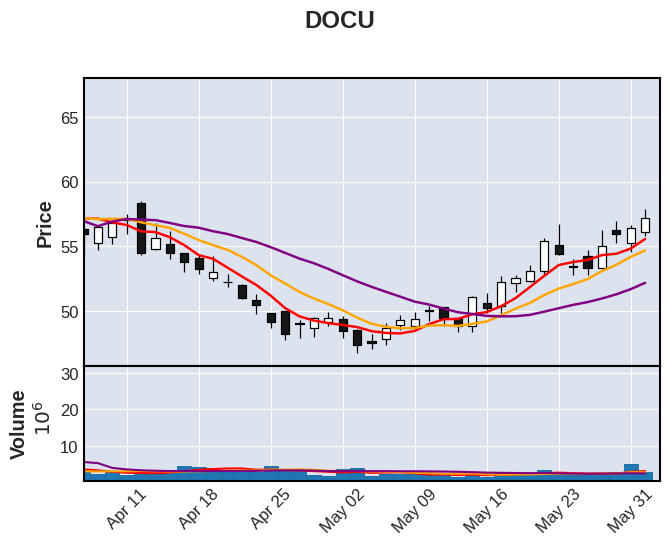

FSLR


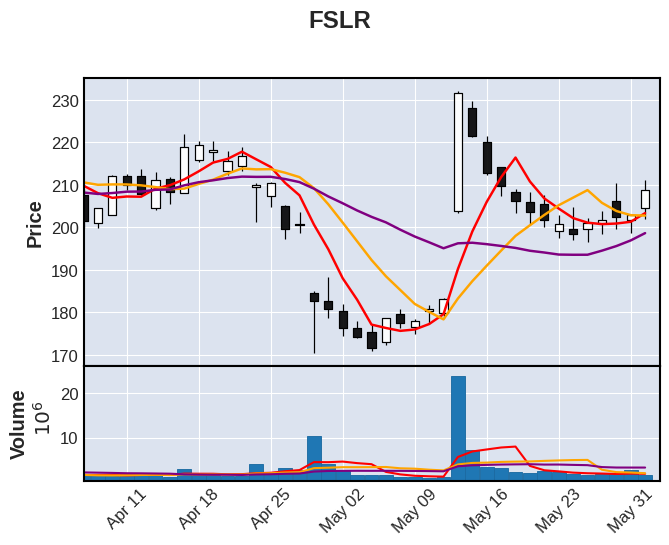

FUBO


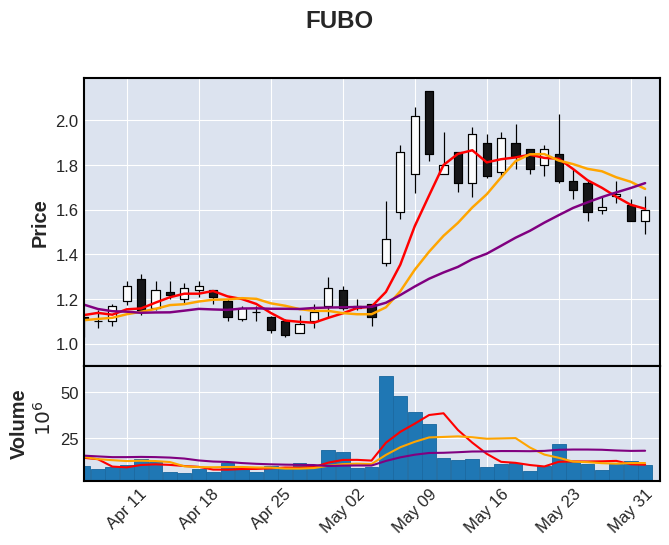

GME


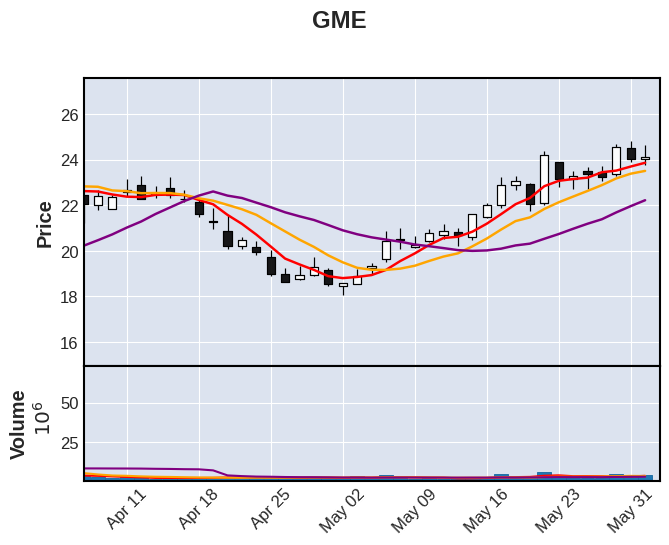

HIMS


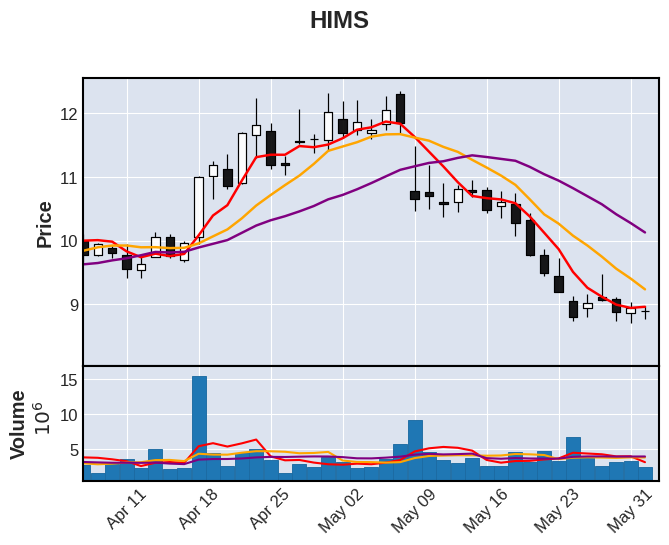

KSS


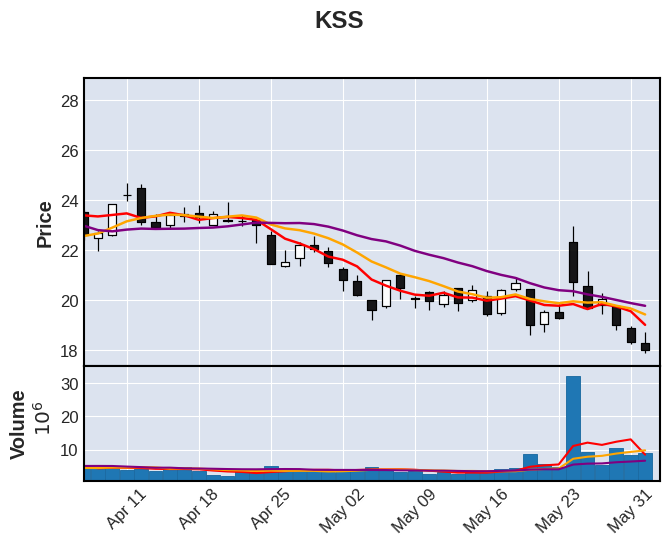

MDB


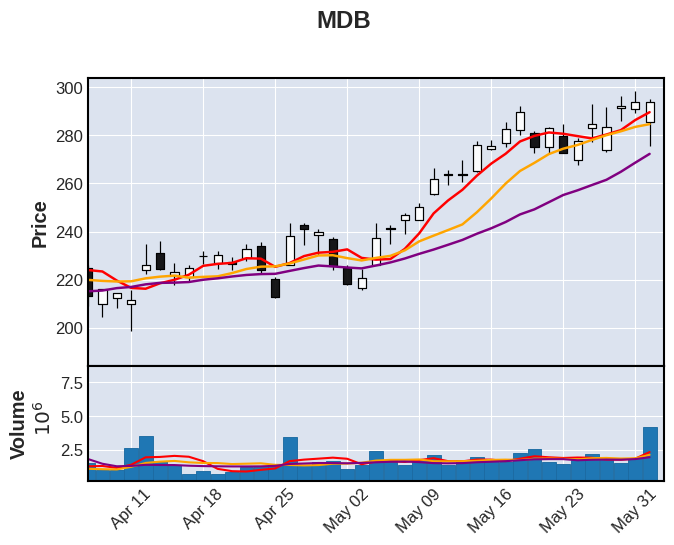

MRNA


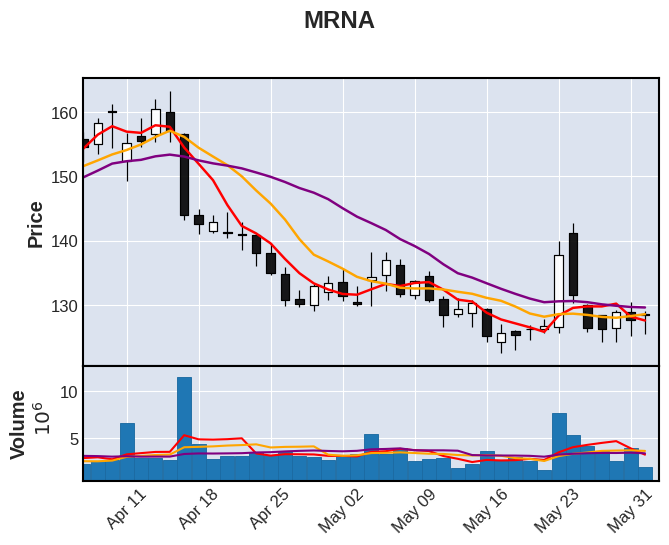

NET


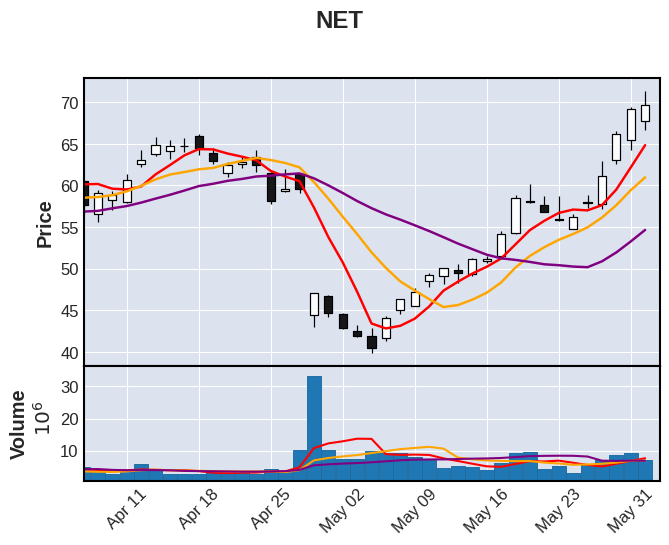

NIO


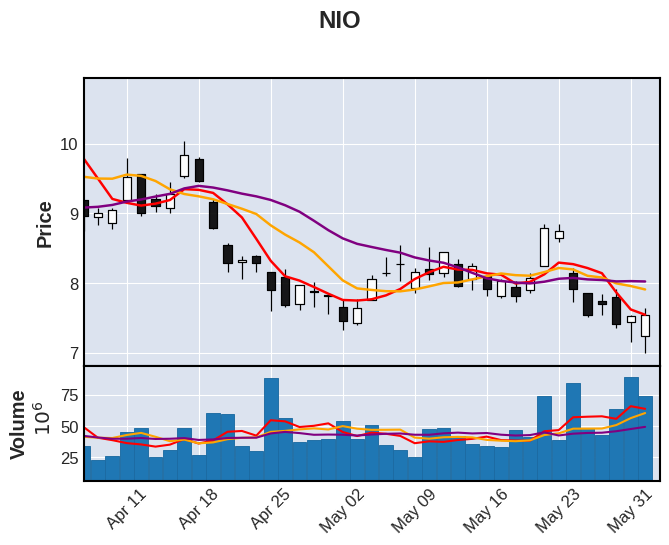

OKTA


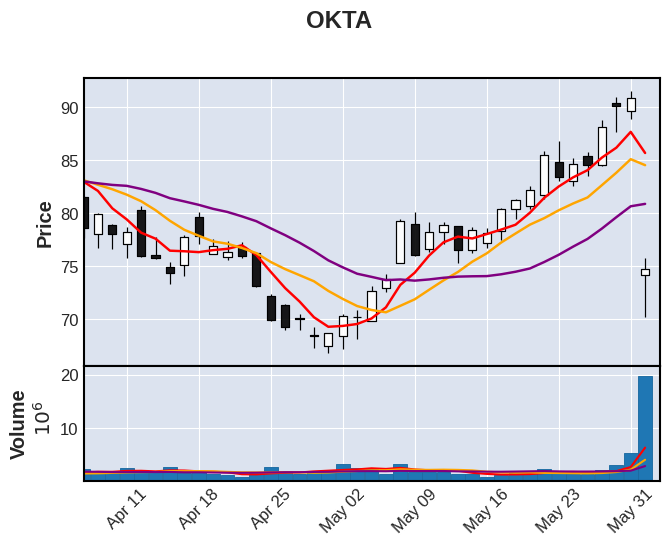

OXY


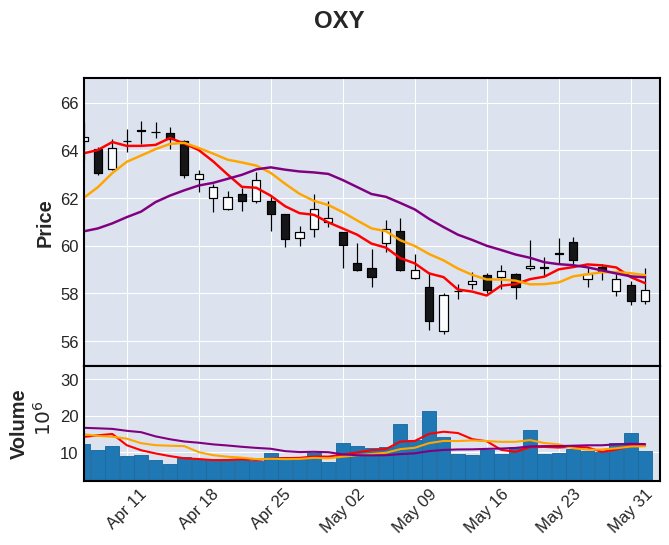

PLTR


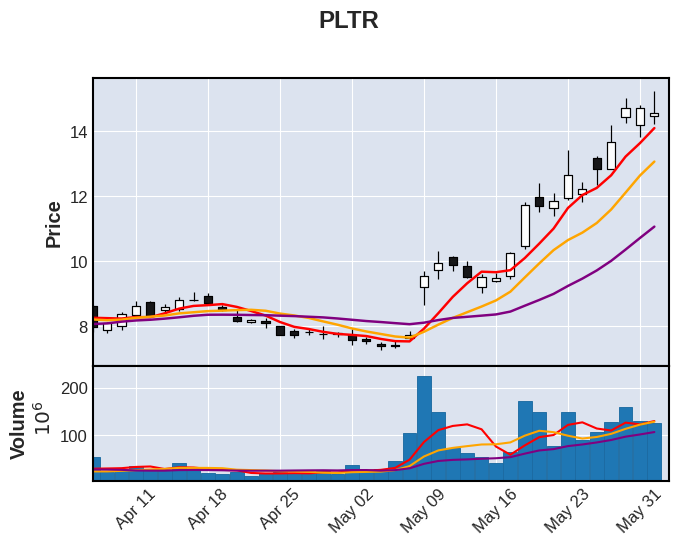

PTON


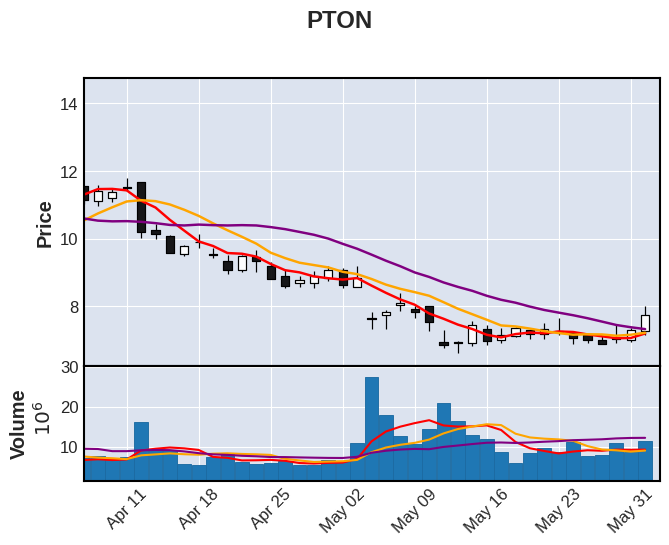

RETA


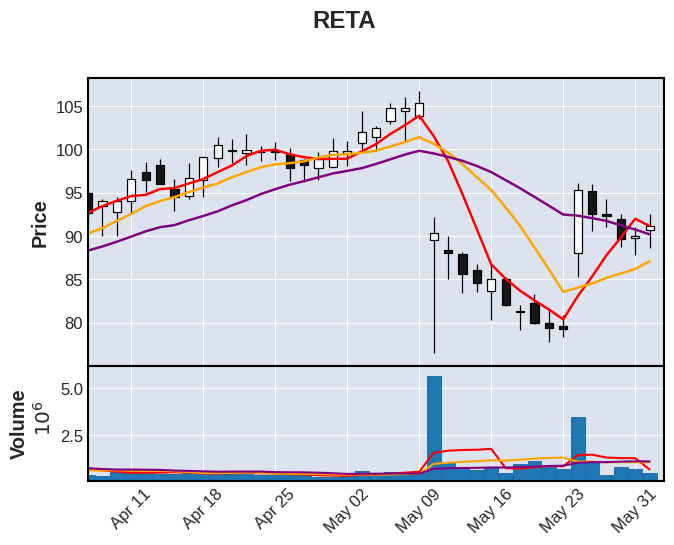

RIOT


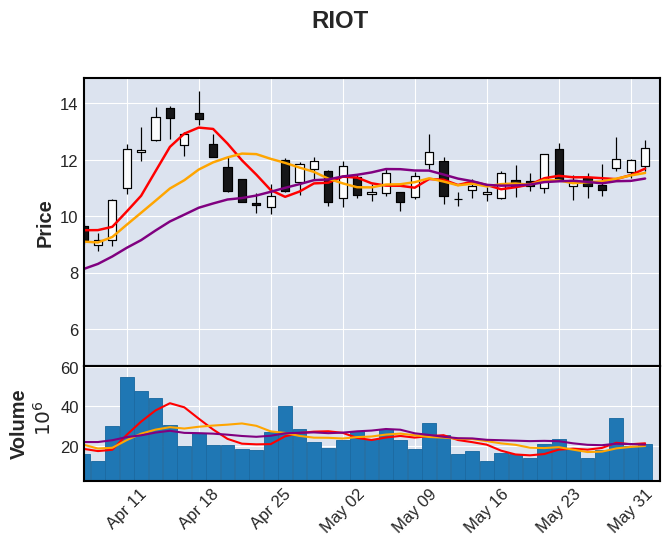

RIVN


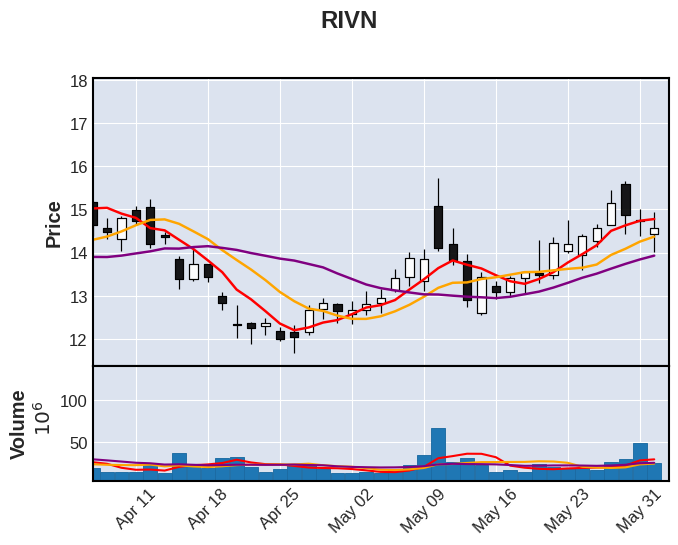

RKT


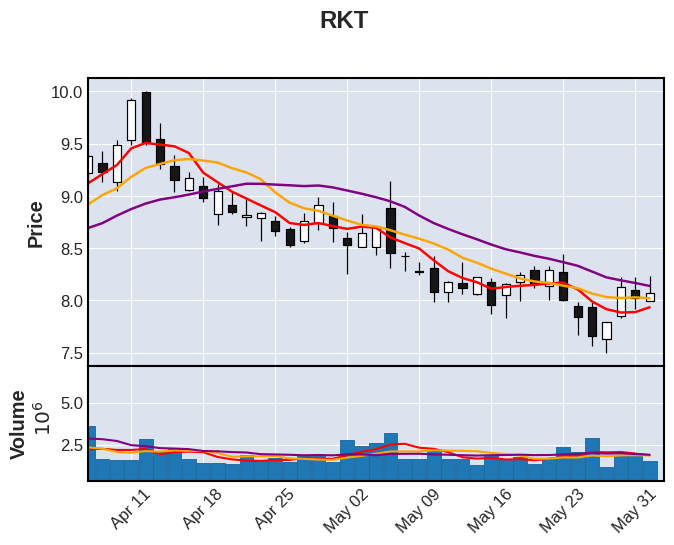

SNAP


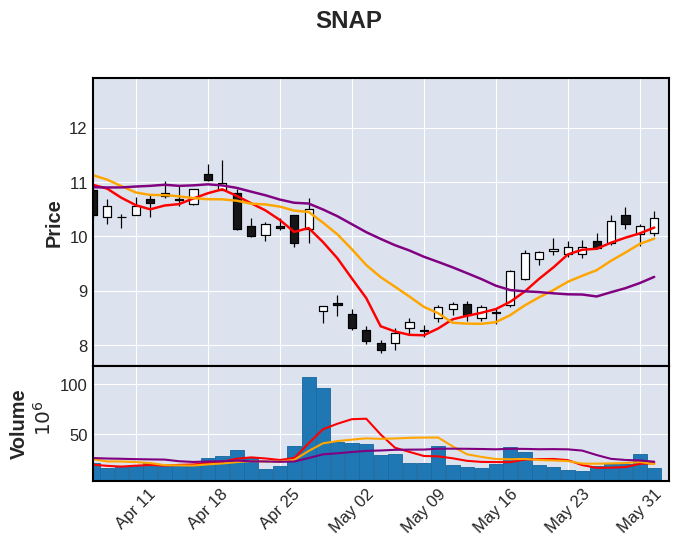

SPCE


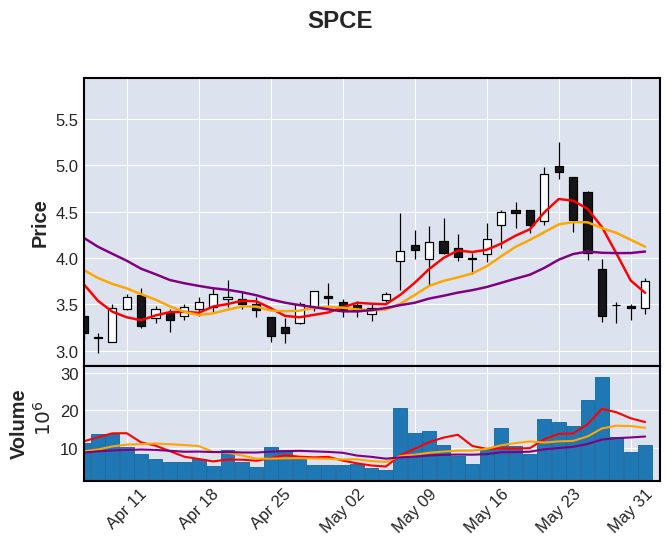

U


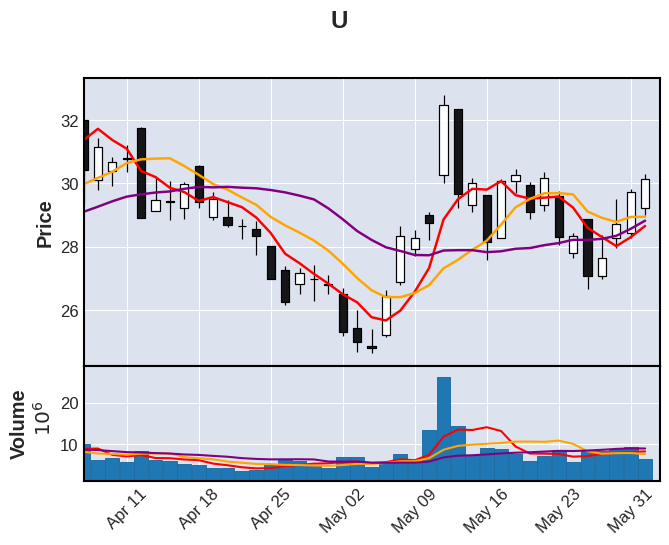

WOLF


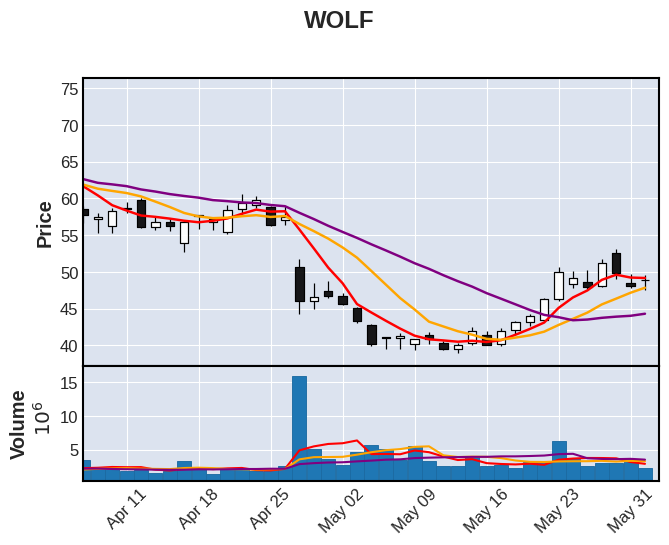

WWE


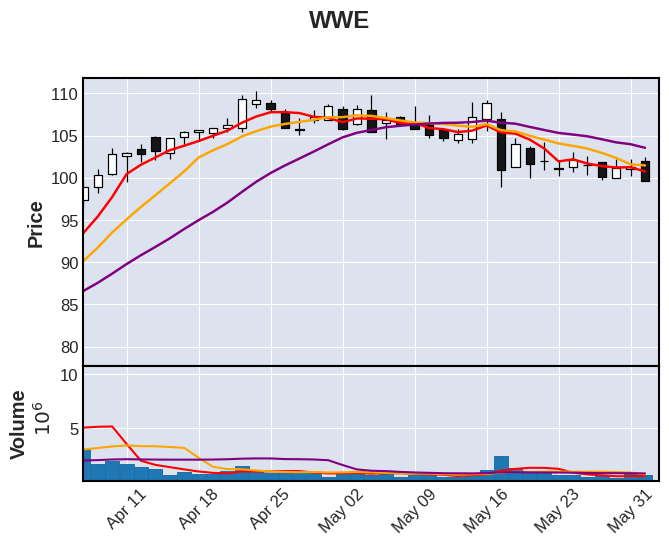

ZM


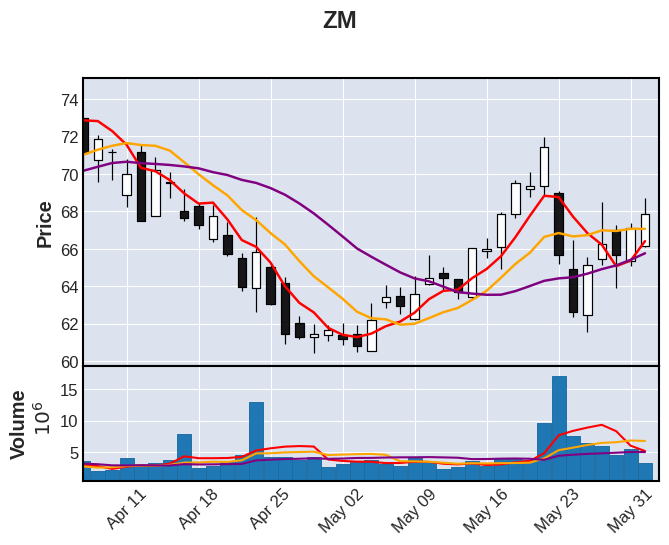

In [ ]:
for key in meme.keys():
  if key not in focus.keys():
    print(f"{key}")
    candle_plot(meme[key], key)

# High potential: 10ma continuously growing 
- Use this on full ticker lists to look for potential stocks (russell, s&p500...)
- Very strict constraint, stocks shown here have high potential


In [ ]:
growth_2 = []
growth_5 = []

for k in russell.keys():
  diff = np.array(russell[k][-19:]["MA10"]) - np.array(russell[k][-20:-1]["MA10"])

  if not np.any(diff < 0):
    if (diff[-5:] == sorted(diff[-5:])).all():
      growth_5.append(k)
    elif (diff[-2:] == sorted(diff[-2:])).all():
      growth_2.append(k)

print(len(growth_2), len(growth_5))

9 3


CEG


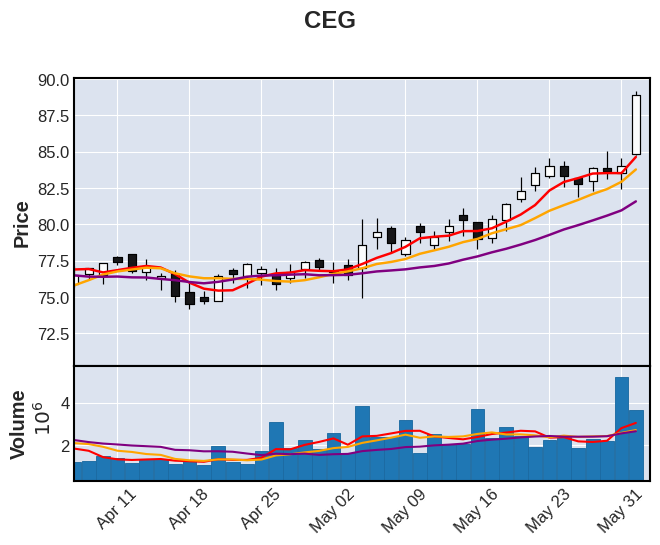

CPA


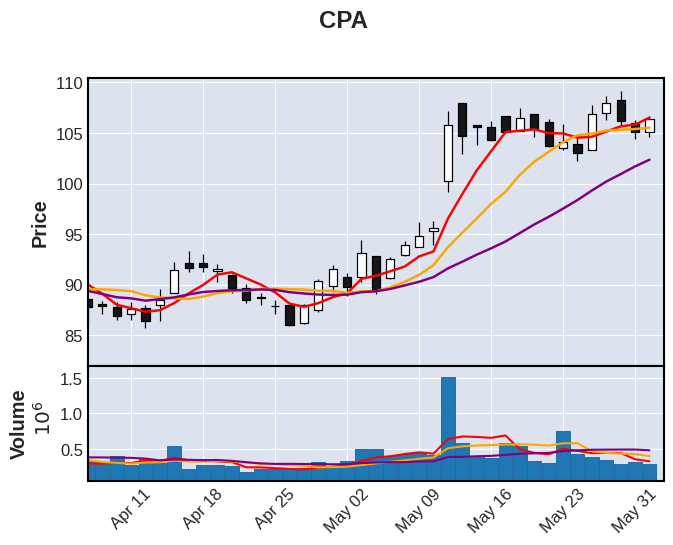

ENTG


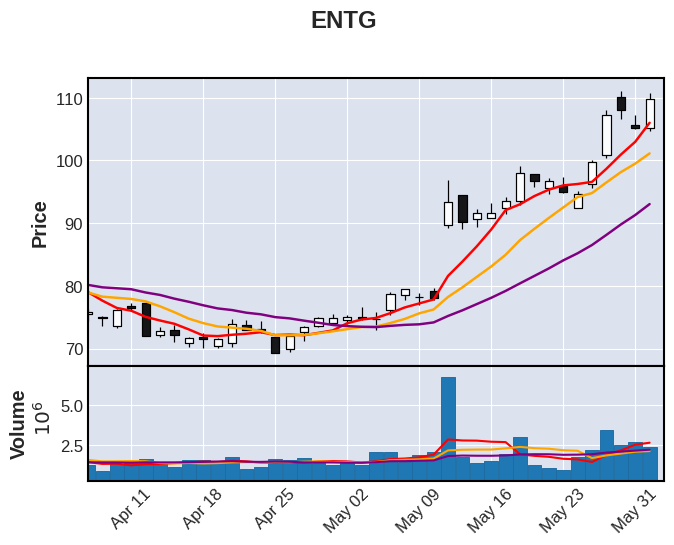

KLAC


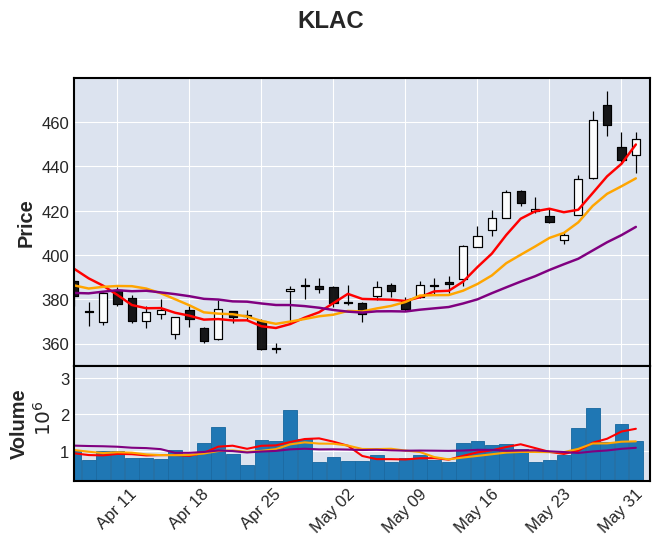

MRVL


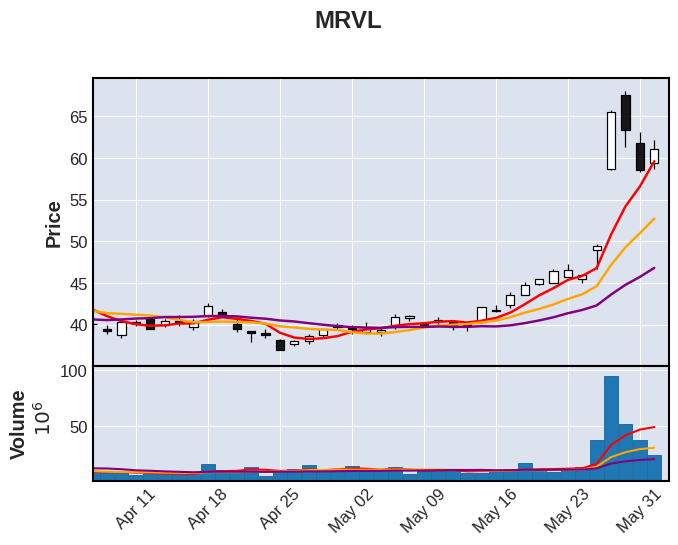

MSFT


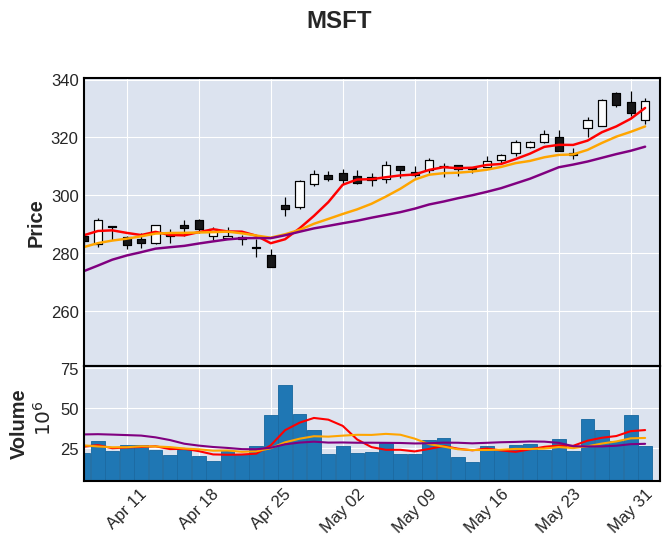

NVDA


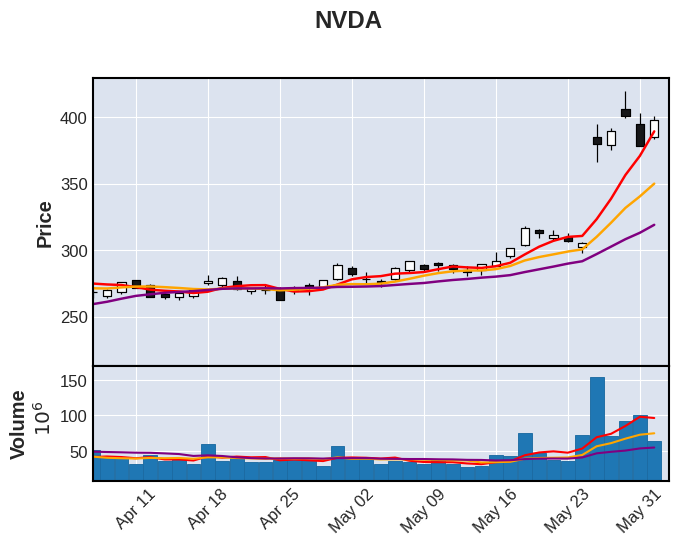

OSH


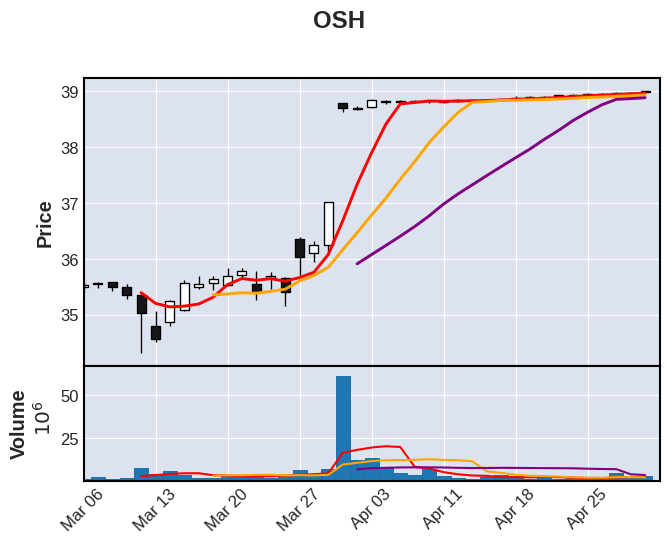

VSAT


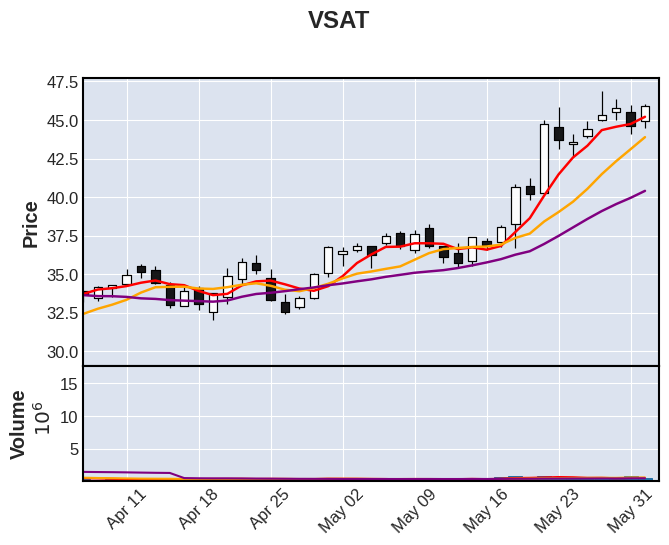

In [ ]:
for symbol in growth_2:
  print(f"{symbol}")
  candle_plot(russell[symbol], symbol)

# Avg potential: Close price > 5ma over certain days
- Use this on full ticker lists to look for potential stocks (russell, s&p500...)
- Not a strict constraint, may show a lot of stock that needs further inspection

In [ ]:
momentum_5 = []
momentum_10 = []
momentum_15 = []

for k in russell.keys():
  momentum = np.where(russell[k][-20:]["Close"] > russell[k][-20:]["MA5"], 1, 0)

  # Save in order so mom_15 won't be in mom_5
  if sum(momentum[-15:]) == 15:
    momentum_15.append(k)
  elif sum(momentum[-10:]) == 10:
    momentum_10.append(k)
  elif sum(momentum[-5:]) == 5:
    momentum_5.append(k)

print(len(momentum_5), len(momentum_10), len(momentum_15))

56 13 3


TEAM


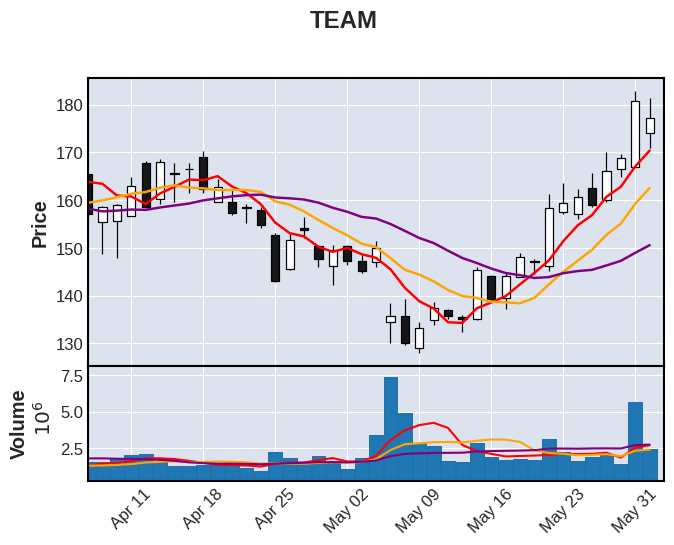

CCCS


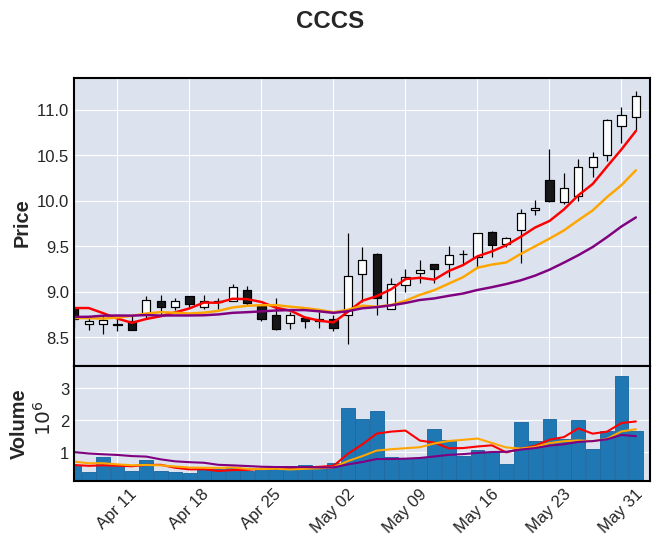

ZS


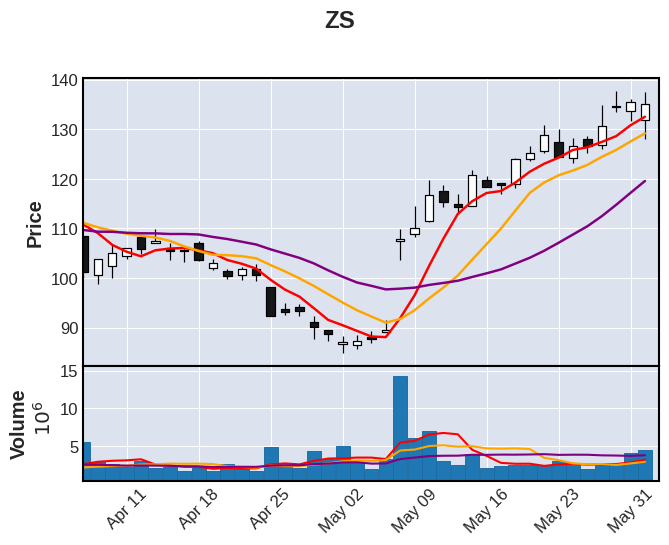

In [ ]:
for symbol in momentum_15:
  print(f"{symbol}")
  candle_plot(russell[symbol], symbol)